# Derivation of L2L3 MC corrections


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        r_axis = hist.Bin("r", "RECO / GEN response", 200, 0, 5)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'r_pt_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptveta':hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, r_axis),
            'r_m_ptvm':hist.Hist("Counts", dataset_axis, pt_axis, m_axis, r_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'] * (1 - df['Jet_rawFactor']),
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass'],
            jetId=df['Jet_jetId']
            )        
        
        GenJets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt=df['GenJet_pt'],
            eta=df['GenJet_eta'],
            phi=df['GenJet_phi'],
            mass=df['GenJet_mass']
            )
        
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += Jets.size

        jetId_cut = (Jets.jetId > 0)        
        Jets = Jets[jetId_cut]
        output['cutflow']['>=1 with loose id'] += jetId_cut.any().sum()
        twoJets = (Jets.counts >= 2)        
        output['cutflow']['>=2 reco jets'] += twoJets.sum()
        twoGens = (GenJets.counts >= 2)
        output['cutflow']['>=2 gen jets'] += twoGens.sum()
        

        #print("4")
        Jets = Jets[twoJets & twoGens]
        GenJets = GenJets[twoJets & twoGens]
        
        
        dphi_index = Jets.p4[:,0].delta_phi( Jets.p4[:,1] ) > 1.8
        #print('dphi_index shape', dphi_index.shape)
        #print('Jets shape', Jets.shape)
        #print('Gens shape', GenJets.shape)
        output['cutflow']['dPhi > 1.8'] += dphi_index.sum()
        

        Jets = Jets[dphi_index]
        GenJets = GenJets[dphi_index]
        
        #print("6")
        #print("Jets shape", Jets[:,0:2].shape)
        #print("GenJets shape", GenJets.shape)
        
        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
        #print("pairing shape:", pairing.shape)
        
        index_of_minimized = metric.argmin()
        dr_cut = (metric[index_of_minimized] < 0.2)
        best_pairings_that_pass_dr_cut = pairing[index_of_minimized][dr_cut]
        genrecos = best_pairings_that_pass_dr_cut.flatten(axis=1)
        #print("genrecos shape:", genrecos.shape)
        ptresponse = genrecos.i0.pt / genrecos.i1.pt
        
        output['pt'].fill(dataset=dataset,
                            pt=Jets.pt.flatten())
        output['eta'].fill(dataset=dataset, 
                                 eta=Jets.eta.flatten())
        output['r_pt_ptveta'].fill( dataset=dataset, pt=genrecos.i1.pt.flatten(), eta=genrecos.i1.eta.flatten(), r=ptresponse.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
   

# Get the sample metadata
samples = json.load( open('samples_qcdflat.json') )

prefix = '/mnt/data/cms/store/mc/RunIIFall17NanoAODv5/'
fileset = {}
for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    fileset[name] = glob.glob(prefix + name + '/*/*/*/*.root')

tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyJECL2L3Processor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=500000,
                                 )


elapsed = time.time() - tstart
print(output)

Processing: 100%|██████████| 44/44 [02:09<00:00,  2.95s/items]

{'pt': <Hist (dataset,pt) instance at 0x7f07d4c6aa20>, 'eta': <Hist (dataset,eta) instance at 0x7f0799c1f0b8>, 'r_pt_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f0799c1f128>, 'r_m_ptveta': <Hist (dataset,pt,eta,r) instance at 0x7f0799c1f390>, 'r_m_ptvm': <Hist (dataset,pt,m,r) instance at 0x7f0799c1fd68>, 'cutflow': defaultdict(<class 'int'>, {'all events': 18455107, '>=1 with loose id': 18427355, '>=2 reco jets': 18303605, '>=2 gen jets': 18304968, 'dPhi > 1.8': 8669779})}


In [4]:
import matplotlib.pyplot as plt

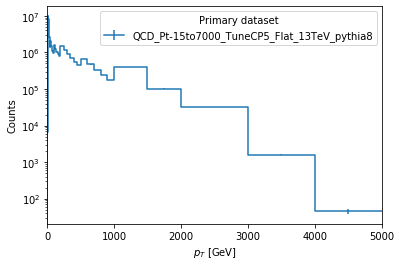

In [5]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

In [6]:
plt.rcParams["image.cmap"] = 'Blues'

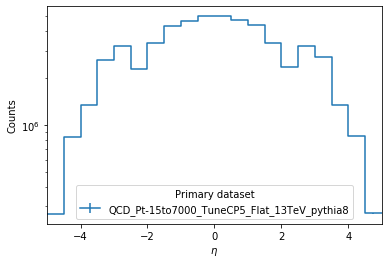

In [7]:
fig, ax = hist.plotgrid(output['eta'], overlay="dataset", stack=False
                                 )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

/usr/local/jupyter/lib/python3.6/site-packages/coffea/hist/hist_tools.py:824: FutureWarning: Hist.project() has been renamed to Hist.integrate().  In the future, Hist.project() will provide different functionality
  warnings.warn("Hist.project() has been renamed to Hist.integrate().  In the future, Hist.project() will provide different functionality", FutureWarning)
/usr/local/jupyter/lib/python3.6/site-packages/coffea/hist/plot.py:388: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


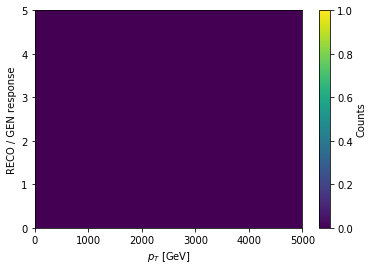

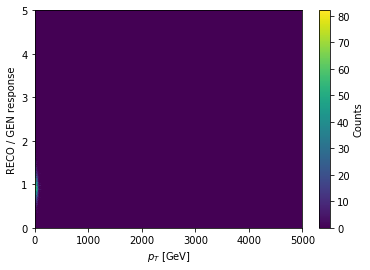

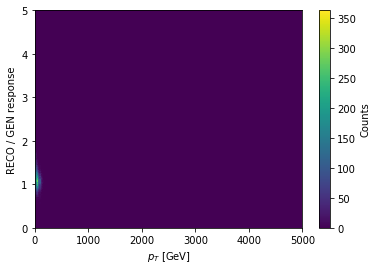

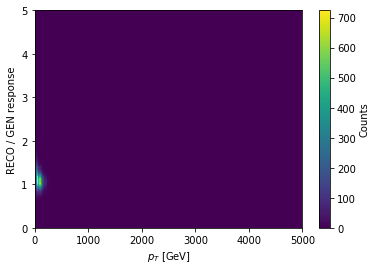

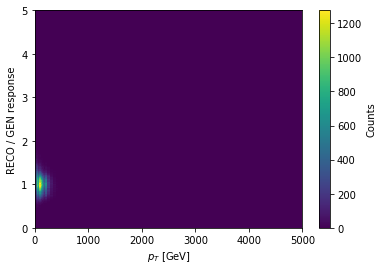

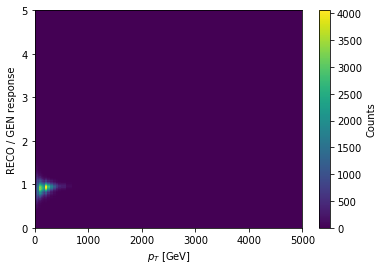

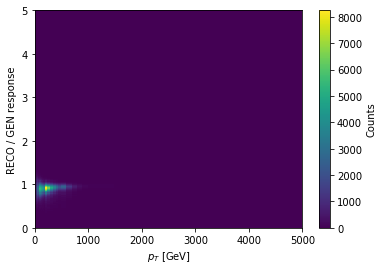

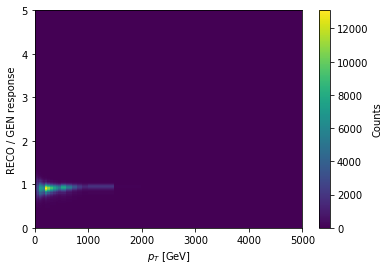

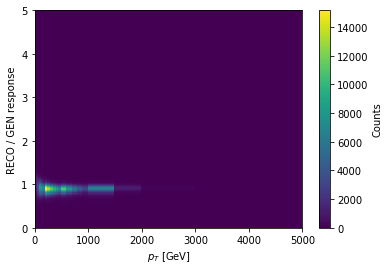

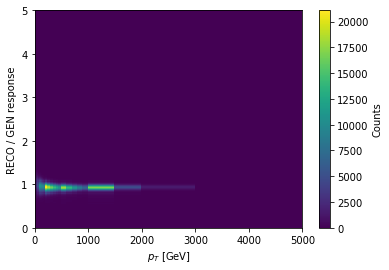

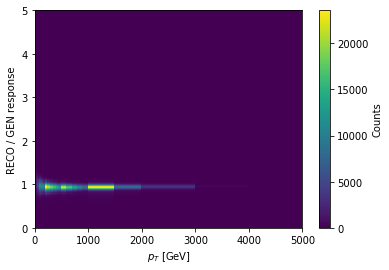

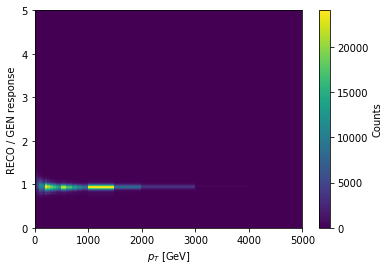

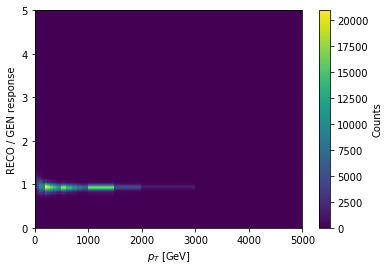

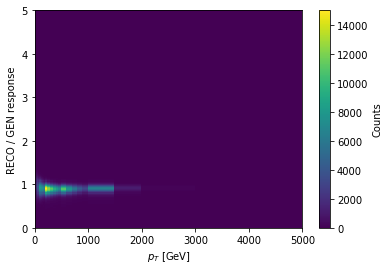

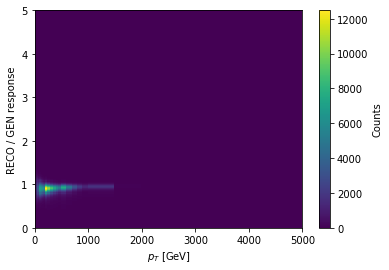

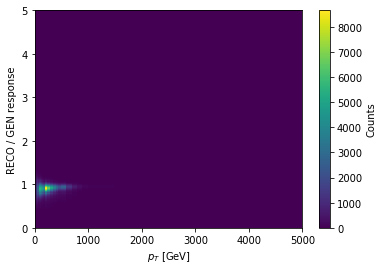

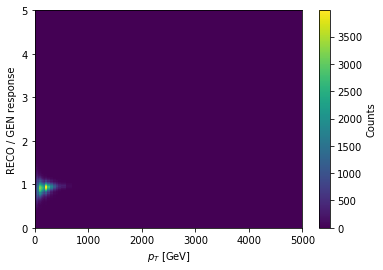

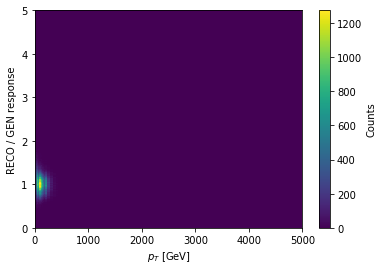

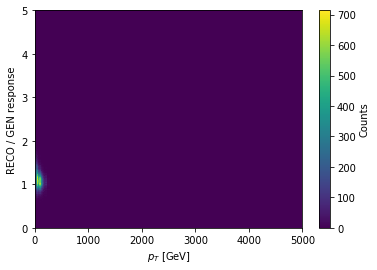

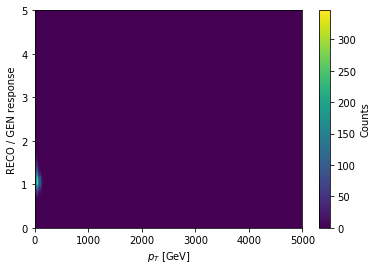

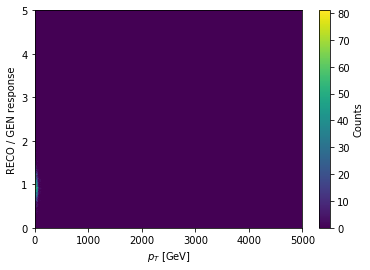

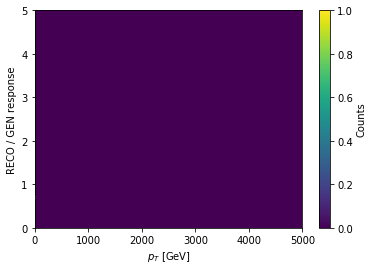

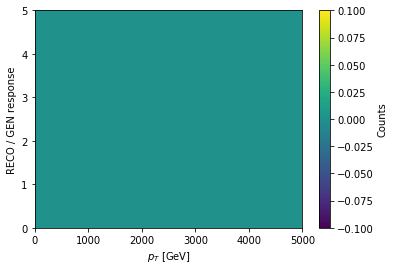

In [8]:


for i in output['r_pt_ptveta'].axis('eta'):
    fig, ax, _ = hist.plot2d(output['r_pt_ptveta'].project('dataset').project('eta', the_slice=i),
                             xaxis='pt')


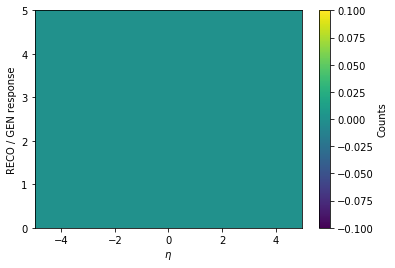

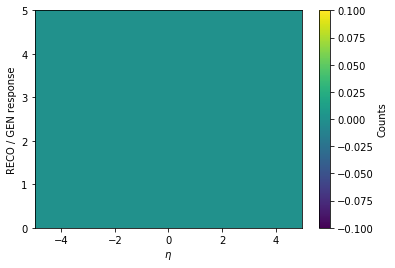

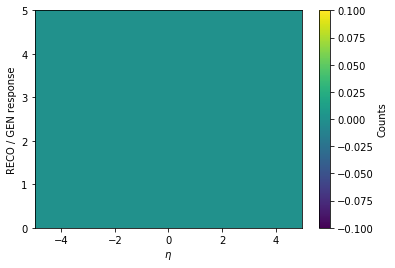

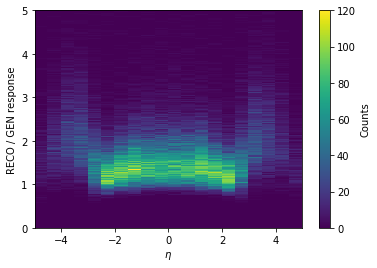

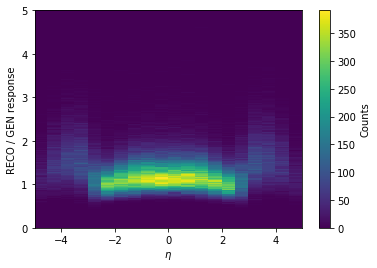

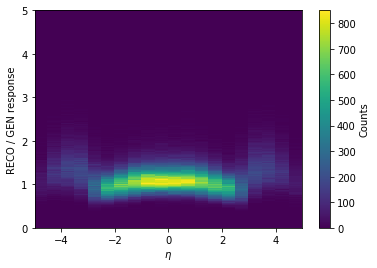

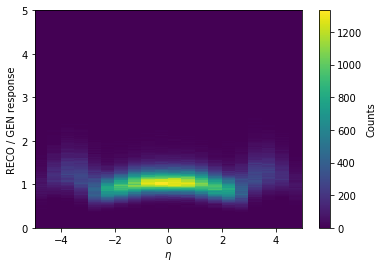

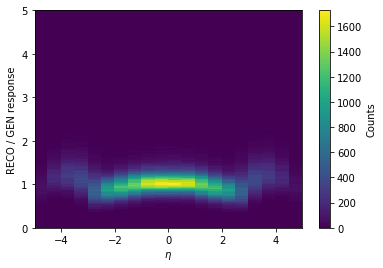

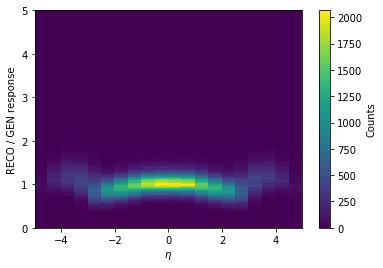

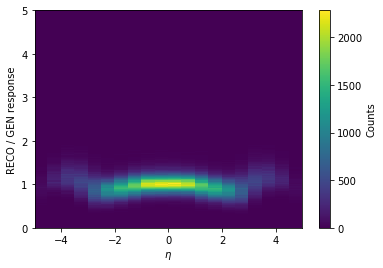

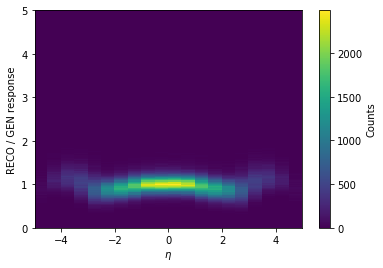

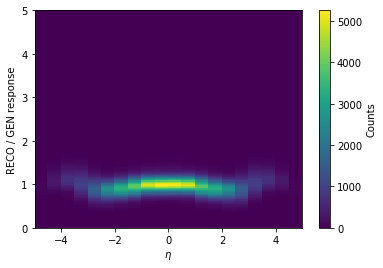

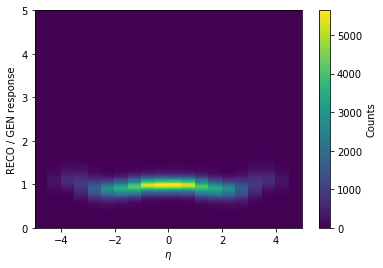

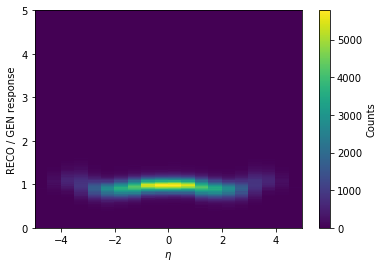

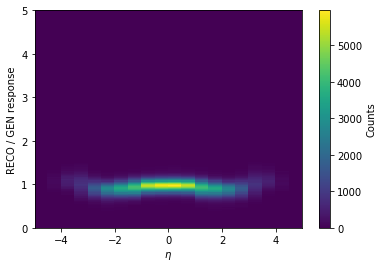

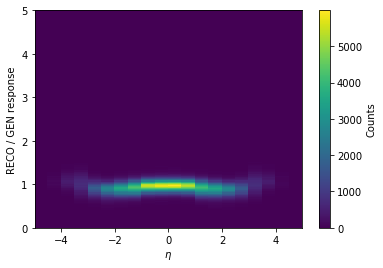

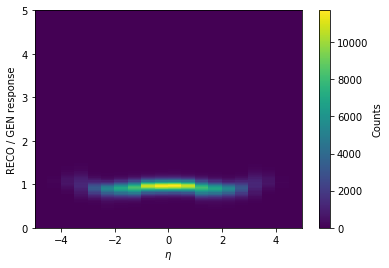

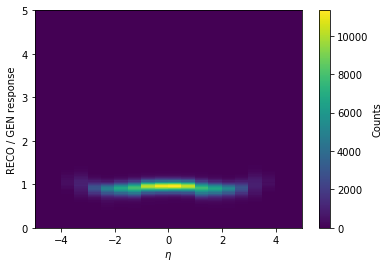

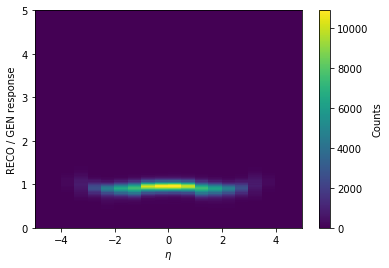

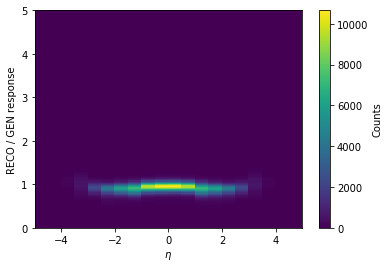

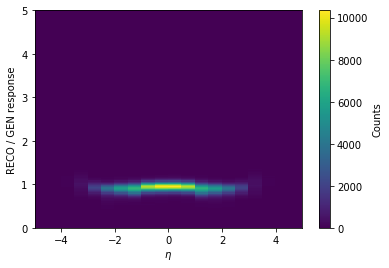

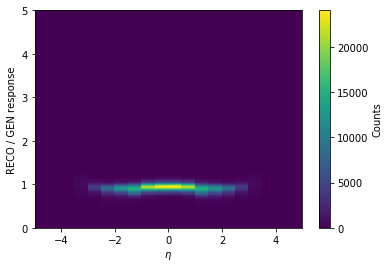

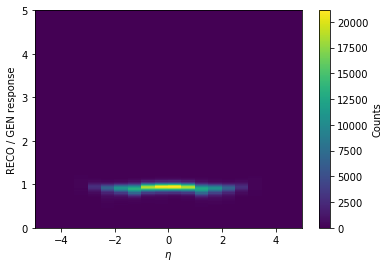

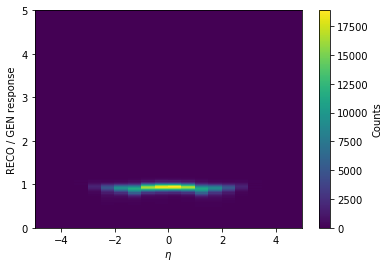

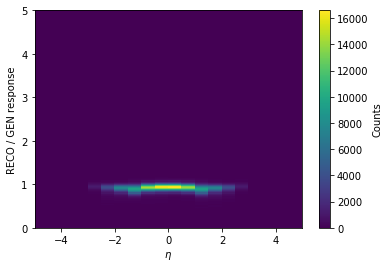

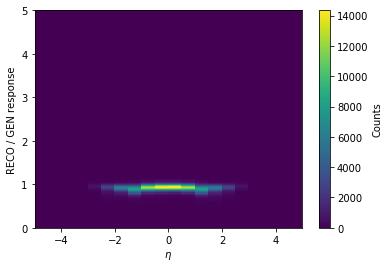

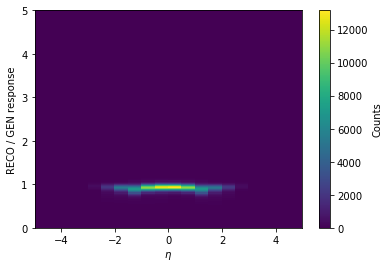

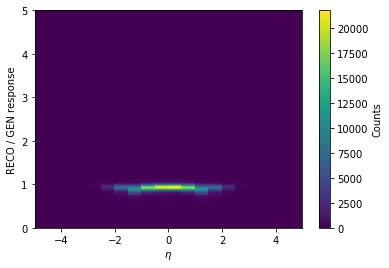

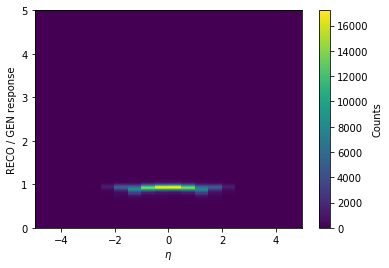

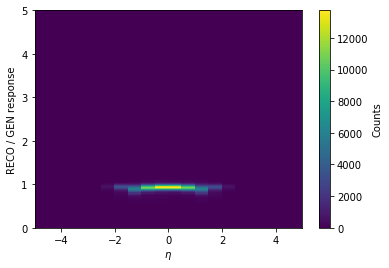

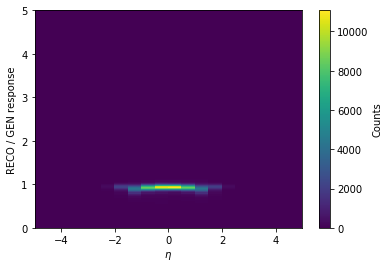

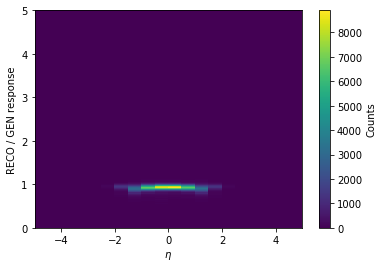

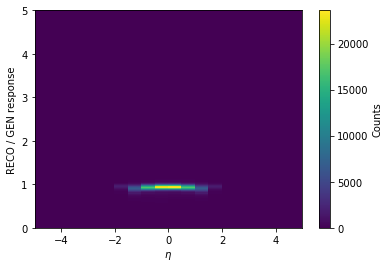

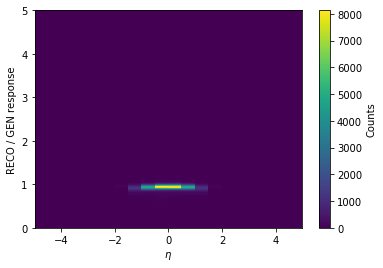

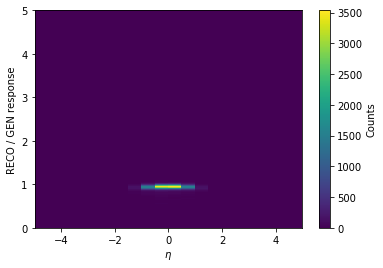

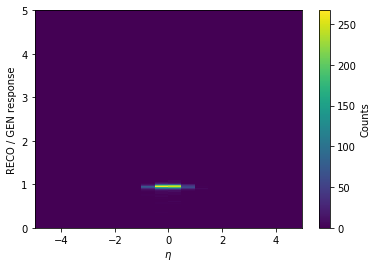

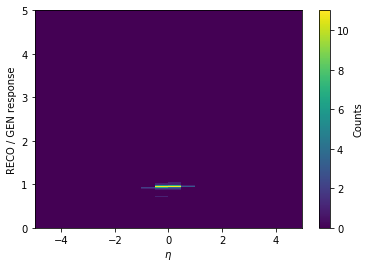

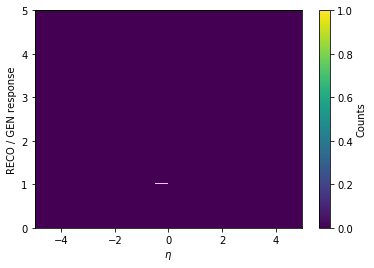

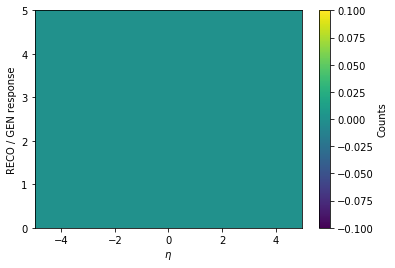

In [9]:


for i in output['r_pt_ptveta'].axis('pt'):
    fig, ax, _ = hist.plot2d(output['r_pt_ptveta'].project('dataset').project('pt', the_slice=i),xaxis='eta')

    



In [10]:
print(output['r_m_ptvm'])

<Hist (dataset,pt,m,r) instance at 0x7f0799c1fd68>


In [11]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 141197.980937157
